In [126]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 10)

In [127]:
#%% settings
#for windows
#file = 'sample_data\\201805\\RL7785--1K-20180517102718_crv.csv'
#file_rlt = 'sample_data\\201805\\RL7785--1K-20180517102718_rlt.csv'
file = 'sample_data/201805/RL7785--1K-20180517102718_crv.csv'
file_rlt = 'sample_data/201805/RL7785--1K-20180517102718_rlt.csv'

In [130]:
#%% read files and parameters
data = pd.read_csv(file, sep=',', encoding='shift_jis', skiprows=1, index_col=0)
data_rlt = pd.read_csv(file_rlt, sep=',', encoding='shift_jis')
data.head()

,mm,N,mm.1,N.1,mm.2,N.2,mm.3,N.3,mm.4,N.4
1,0.000,0.10,0.000,0.10,0.000,0.10,0.000,0.11,0.000,0.10
2,0.001,0.18,0.001,0.16,0.001,0.12,0.001,0.13,0.001,0.12
3,0.002,0.25,0.002,0.23,0.002,0.18,0.002,0.20,0.002,0.20
4,0.003,0.32,0.003,0.33,0.003,0.26,0.003,0.25,0.003,0.28
5,0.004,0.41,0.004,0.41,0.004,0.31,0.004,0.32,0.004,0.36


In [131]:
L = 64  # span
b = float(data_rlt.iloc[2, 3]) # width of first specimen
h = float(data_rlt.iloc[2, 4]) # height of first specimen
print('span, width, height of first specimen:', L, ',', b, ',', h)

span, width, height of first specimen: 64 , 9.815 , 3.945


In [132]:
#cut out curve of first specimen
col = ['mm', 'N']
data = data.reindex(columns=col)
data.head()

,mm,N
1,0.000,0.10
2,0.001,0.18
3,0.002,0.25
4,0.003,0.32
5,0.004,0.41


In [140]:
#%% convert (mm, N) to (%, MPa)
# sigma = 3*F*L / (2*b*h^2)
# epsilon = 6*100*s*h / (L^2)
# F: load, L:span = 64 mm, b:width, h:height, s=strain/mm

data['strain'] = data['mm'] * 6 * 100 * h / L / L
data['stress'] = data['N'] * 3 * L / (2 * b * h * h)
data

,mm,N,strain,stress
1,0.000,0.10,0.000000,0.062847
2,0.001,0.18,0.000578,0.113125
3,0.002,0.25,0.001156,0.157118
4,0.003,0.32,0.001734,0.201111
5,0.004,0.41,0.002312,0.257674
...,...,...,...,...
458,2.830,138.00,1.635403,86.729332
459,2.930,139.20,1.693191,87.483500
460,3.030,139.90,1.750979,87.923431
461,3.130,140.00,1.808767,87.986279


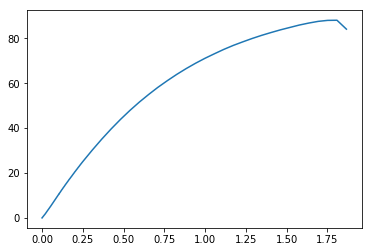

In [134]:
plt.plot(data['strain'], data['stress'])
plt.xlabel = 'strain / %'
plt.ylabel = 'stress / N'
plt.show()

In [227]:
marker = pd.DataFrame({'strain': {'m0': 0.0, 'm1': 0.1, 'm2': 0.2}, 'marker': {'m0': True, 'm1': True, 'm2': True}})
marker = pd.DataFrame({'strain': np.arange(0, 10, 0.1), 'marker': True})
marker

,marker,strain
0,True,0.0
1,True,0.1
2,True,0.2
3,True,0.3
4,True,0.4
...,...,...
95,True,9.5
96,True,9.6
97,True,9.7
98,True,9.8


In [228]:
data_marked = pd.merge(data, marker, on='strain', how='outer')
data_marked.rename(data_marked['strain'], inplace=True)

In [229]:
data_marked.sort_values(by=['strain'], inplace=True)
data_marked.interpolate(method='slinear', limit=1, inplace=True)
data_marked['marker'].fillna('False', inplace=True)
data_skipped = data_marked[data_marked['marker']==True]
data_skipped

,mm,N,strain,stress,marker
0.0,0.000000,0.100000,0.0,0.062847,True
0.1,0.173046,16.405986,0.1,10.310726,True
0.2,0.346092,32.565526,0.2,20.466567,True
0.3,0.519138,46.977190,0.3,29.523915,True
0.4,0.692184,60.090854,0.4,37.765505,True
...,...,...,...,...,...
9.5,NaN,NaN,9.5,NaN,True
9.6,NaN,NaN,9.6,NaN,True
9.7,NaN,NaN,9.7,NaN,True
9.8,NaN,NaN,9.8,NaN,True


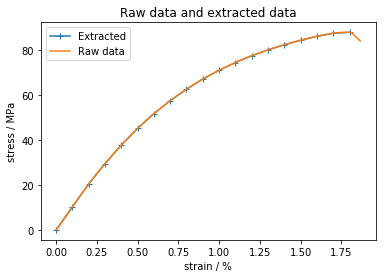

In [246]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(data_skipped['strain'], data_skipped['stress'], marker='+', label='Extracted')
ax.plot(data['strain'], data['stress'], label='Raw data')
ax.set_xlabel('strain / %')
ax.set_ylabel('stress / MPa')
ax.set_title('Raw data and extracted data')
ax.legend(loc='best')
plt.show()

In [247]:
data_skipped

,mm,N,strain,stress,marker
0.0,0.000000,0.100000,0.0,0.062847,True
0.1,0.173046,16.405986,0.1,10.310726,True
0.2,0.346092,32.565526,0.2,20.466567,True
0.3,0.519138,46.977190,0.3,29.523915,True
0.4,0.692184,60.090854,0.4,37.765505,True
...,...,...,...,...,...
9.5,NaN,NaN,9.5,NaN,True
9.6,NaN,NaN,9.6,NaN,True
9.7,NaN,NaN,9.7,NaN,True
9.8,NaN,NaN,9.8,NaN,True
